In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from typing import List
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
tqdm.pandas()

/opt/anaconda3/envs/dl_course/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '../prac2/cifar-10/'
train_val_csv = os.path.join(data_dir, 'trainLabels.csv')
train_imgs_dir = os.path.join(data_dir, 'train')

df = pd.read_csv(train_val_csv)

df.head(5)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [3]:
# let's look at the first image
img_id = 1
img_fname = os.path.join(train_imgs_dir, f'{img_id}.png')
img_fname

'../prac2/cifar-10/train/1.png'

In [4]:
img = Image.open(img_fname)

In [5]:
np.array(img).shape

(32, 32, 3)

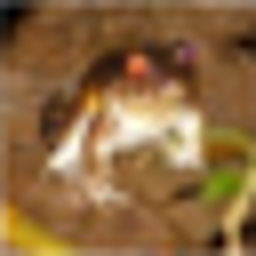

In [6]:
img.resize((256,256))

In [7]:
np.array(img).shape

(32, 32, 3)

In [8]:
np.array(img).dtype, np.array(img).min(), np.array(img).max()

(dtype('uint8'), 0, 255)

### Main pipeline

In [9]:
class Cifar10Dataset(Dataset):
    def __init__(self, fnames:List[str], labels:List[int]=None, transform=None):
        self.labels = labels
        self.fnames = fnames

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        label = self.labels[idx] if self.labels is not None else None

        img = Image.open(fname)
        img = np.array(img, dtype=float)
        img = np.transpose(img, (2, 0, 1))/255
        return fname, torch.tensor(img), label
    
def collate_fn(batch_items):
    fnames = [x[0] for x in batch_items]
    images = [x[1] for x in batch_items]
    labels = [x[2] for x in batch_items]

    images = torch.stack(images, dim=0).type(torch.float)
    labels = torch.tensor(labels) if labels[0] is not None else labels
    return fnames, images, labels
    

In [10]:
class ClfModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [11]:
def load_data(train_val_csv, train_val_img_dir, test_img_dir, batch_size):
    labels_map = {
        'airplane':0,
        'automobile':1,
        'bird':2,
        'cat':3,
        'deer':4,
        'dog':5,
        'frog':6,
        'horse':7,
        'ship':8,
        'truck':9,

    }
    
    train_val_df = pd.read_csv(train_val_csv)
    train_df, val_df = train_test_split(train_val_df, test_size=0.2)
    train_ids, train_labels = train_df.id.values, train_df.label.apply(lambda x: labels_map[x]).astype(int).values
    val_ids, val_labels = val_df.id.astype(int).values, val_df.label.apply(lambda x: labels_map[x]).astype(int).values
    
    train_fnames = [os.path.join(train_val_img_dir, f"{img_id}.png") for img_id in train_ids]
    val_fnames = [os.path.join(train_val_img_dir, f"{img_id}.png") for img_id in val_ids]
    
    test_ids = [x.split('.')[0] for x in os.listdir(test_img_dir)]
    test_fnames = [os.path.join(test_img_dir, f"{img_id}.png") for img_id in test_ids]
    
    
    train_dataset = Cifar10Dataset(train_fnames, train_labels)
    val_dataset = Cifar10Dataset(val_fnames, val_labels)
    test_dataset = Cifar10Dataset(test_fnames)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader

In [12]:
def init_model(lr):
    model = ClfModel()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

def validate(model, criterion, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for fnames, images, labels in tqdm(loader, desc="val"):
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

def train(model, criterion, optimizer, loader, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for fnames, images, labels in tqdm(loader, desc="train"):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            
        val_loss = validate(model, criterion, loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss / len(loader)}, Val Loss: {val_loss}")
            
    return model

In [13]:
def run(train_val_csv, train_imgs_dir, test_imgs_dir, batch_size, lr, epochs):
    train_loader, val_loader, test_loader = load_data(train_val_csv, train_imgs_dir, test_imgs_dir, batch_size)
    model, criterion, optimizer = init_model(lr)
    train(model, criterion, optimizer, train_loader, epochs)
    val_loss = validate(model, criterion, val_loader)
    print(f"Validation loss: {val_loss}")

In [14]:
data_dir = '../prac2/cifar-10/'
train_val_csv = os.path.join(data_dir, 'trainLabels.csv')
train_imgs_dir = os.path.join(data_dir, 'train')
test_imgs_dir = os.path.join(data_dir, 'test')
batch_size = 32
lr = 0.001
epochs = 50

run(train_val_csv, train_imgs_dir, test_imgs_dir, batch_size, lr, epochs)

val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:15<00:00, 78.41it/s]


Epoch 1/50, Train Loss: 1.776584654712677, Val Loss: 1.5286976546287536


train:  34%|██████████████████████████████████████████████▍                                                                                           | 421/1250 [00:07<00:15, 53.66it/s]


KeyboardInterrupt: 